## Set up the environment

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from src.plotting import trim_axs

In [2]:
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_modeling'
interim_dir = f'{top_dir}/data/interim'

In [3]:
scores = []

files = glob(f'{interim_dir}/VisionEncoding/*.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0]
    scores.append(df)

files = glob(f'{interim_dir}/LLMEncoding/*.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0]
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['model_uid', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  \
model_uid                              model_layer_index stream_name                  
sentence-transformers_all-MiniLM-L6-v2 1                 EVC           BertModel-S1   
                                                         EVC           BertModel-S1   
                                                         EVC           BertModel-S1   
                                                         EVC           BertModel-S1   
                                                         high_lateral  BertModel-S1   

                                                                       subj_id  \
model_uid                              model_layer_index stream_name             
sentence-transformers_all-MiniLM-L6-v2 1                 EVC                 1   
                                                         EVC                 2   
                                                         EVC                 3   
                                                         EVC                 4   
                                                         high_lateral        1   

                                                                          score  \
model_uid                              model_layer_index stream_name              
sentence-transformers_all-MiniLM-L6-v2 1                 EVC           0.084923   
                                                         EVC           0.090006   
                                                         EVC           0.092812   
                                                         EVC           0.085410   
                                                         high_lateral  0.126764   

                                                                      method  
model_uid                              model_layer_index stream_name          
sentence-transformers_all-MiniLM-L6-v2 1                 EVC           ridge  
                                                         EVC           ridge  
                                                         EVC           ridge  
                                                         EVC           ridge  
                                                         high_lateral  ridge

In [4]:
avg_scores = scores.reset_index().groupby(['model_uid', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['model_uid', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['model_uid', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_15460/783651595.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['model_uid', 'model_layer_index', 'stream_name']).mean().reset_index()


,model_uid,model_layer_index,stream_name,model_layer,subj_id,score,method
0,sentence-transformers_all-MiniLM-L6-v2,58,EVC,GELUActivation-5-18,1,0.115271,ridge
1,sentence-transformers_all-MiniLM-L6-v2,58,EVC,GELUActivation-5-18,2,0.167904,ridge
2,sentence-transformers_all-MiniLM-L6-v2,58,EVC,GELUActivation-5-18,3,0.135879,ridge
3,sentence-transformers_all-MiniLM-L6-v2,58,EVC,GELUActivation-5-18,4,0.140550,ridge
4,sentence-transformers_all-MiniLM-L6-v2,41,high_lateral,BertOutput-4-6,1,0.177744,ridge


In [5]:
streams = ['EVC']
streams += [f'{level}_{stream}' for level in ['mid', 'high'] for stream in ['ventral', 'lateral', 'parietal']]
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

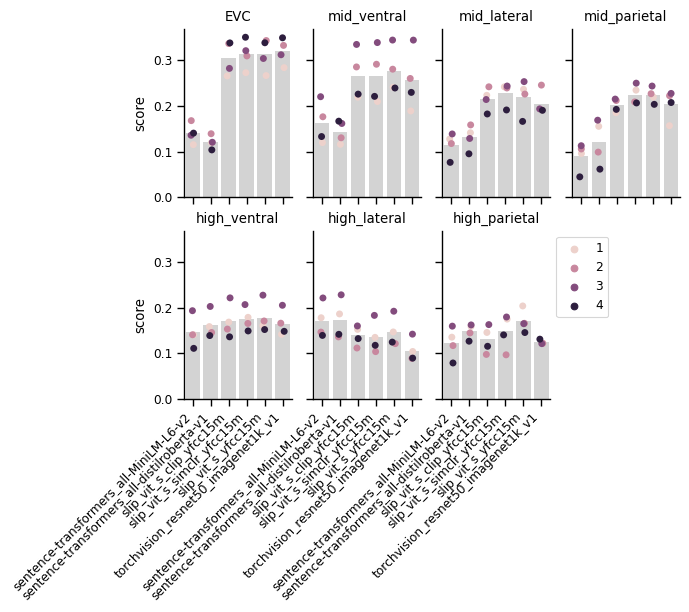

In [17]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True)
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
models = max_scores.model_uid.unique()
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='model_uid', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='model_uid', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(models, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()